In [2]:
%pip install emoji

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
import re

import regex
import emoji

import numpy as np
from collections import Counter

import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

### Paso 1: Definir funciones necesarias

In [10]:
# Obtener los patrones de los números telefónicos de países
phone_patterns = [line.strip().split(';')[1] + ":" for line in open('Data/phone_patterns.txt', 'r')]
print(phone_patterns)

['([+]\\d{2} \\d{3} \\d{3} \\d{3}):', '([+]\\d{2} \\d{1} \\d{2} \\d{4}-\\d{4}):', '([+]\\d{2} \\d{1} \\d{3} \\d{3}-\\d{4}):', '([+]\\d{2} \\d{1} \\d{4} \\d{2}-\\d{4}):', '([+]\\d{2} \\d{2} \\d{4} \\d{4}):', '([+]\\d{2} \\d{3} \\d{3} \\d{4}):', '([+]\\d{2} \\d{2} \\d{5}-\\d{4}):', '([+]\\d{2} \\d{1} \\d{4} \\d{4}):', '([+]\\d{2} \\d{3} \\d{7}):', '([+]\\d{3} \\d{2} \\d{3} \\d{4}):', '([+]\\d{2} \\d{3}-\\d{7}):', '([+]\\d{3} \\d{8}):', '([+]\\d{3} \\d{2} \\d{3} \\d{3}):', '([+]\\d{2} \\d{3} \\d{2} \\d{2} \\d{2}):', '([+]\\d{1} \\(\\d{3}\\) \\d{3}-\\d{4}):', '([+]\\d{1} \\(\\d{3}\\) \\d{3}-\\d{4}):', '([+]\\d{1} \\(\\d{3}\\) \\d{3}-\\d{4}):', '([+]\\d{1} \\(\\d{3}\\) \\d{3}-\\d{4}):', '([+]\\d{1} \\(\\d{3}\\) \\d{3}-\\d{4}):', '([+]\\d{1} \\(\\d{3}\\) \\d{3}-\\d{4}):', '([+]\\d{3} \\d{3}-\\d{4}):', '([+]\\d{3} \\d{4}-\\d{4}):', '([+]\\d{3} \\d{4} \\d{4}):', '([+]\\d{3} \\d{4} \\d{4}):', '([+]\\d{3} \\d{4} \\d{4}):', '([+]\\d{3} \\d{4} \\d{4}):', '([+]\\d{3} \\d{4} \\d{4}):', '([+]\\d{1} \

In [11]:
# Patron regex para identificar el comienzo de cada línea del txt con la fecha y la hora
def IniciaConFechaYHora(s):
    # Ejemplo: '6/30/23, 5:59 PM - ...'
    # Ejemplo real: 21/4/2023, 10:19 p. m. - ...
    patron = '^([1-9]|1[0-9]|2[0-9]|3[0-1])/([1-9]|1[0-2])/(2[0-9][0-9][0-9]), ([0-9]|1[0-2]):([0-9])([0-9])'
    # patron = '^([1-9]|1[0-2])(\/)([1-9]|1[0-9]|2[0-9]|3[0-1])(\/)(2[0-9]), ([0-9]+):([0-9][0-9])\s?([AP][M]) -'
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de fecha y hora
    if resultado:
        return True
    return False

# Patrón para encontrar a los miembros del grupo dentro del txt
def EncontrarMiembro(s):
    patrones = [
        '([\w]+):',                                # Nombre
        '([\w]+[\s]+[\w]+):',                      # Nombre + Apellido
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',            # Nombre 1 + Nombre 2 + Apellido
        '([\w]+[\s]+[\w]+[\s]+[\w]+[\s]+[\w]+):',  # Nombre 1 + Nombre 2+ Nombre 3 + Apellido
        '([\w]+[\s])[\u263a-\U0001f999]+:',        # Nombre + Emoji
    ]
    patrones+=phone_patterns # Se añade los patrones de los números telefónicos

    patron = '^' + '|'.join(patrones)
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de miembro
    if resultado:
        return True
    return False

# Separar las partes de cada línea del txt: Fecha, Hora, Miembro y Mensaje
def ObtenerPartes(linea):
    # Ejemplo: '9/16/23, 5:59 PM - Sandreke: Todos debemos aprender a analizar datos'
    splitLinea = linea.split(' - ')
    FechaHora = splitLinea[0]                     # '9/16/23, 5:59 PM'
    splitFechaHora = FechaHora.split(', ')
    Fecha = splitFechaHora[0]                    # '9/16/23'
    Hora = ' '.join(splitFechaHora[1:])          # '5:59 PM'
    Mensaje = ' '.join(splitLinea[1:])             # 'Sandreke: Todos debemos aprender a analizar datos'
    if EncontrarMiembro(Mensaje):
        splitMensaje = Mensaje.split(': ')
        Miembro = splitMensaje[0]               # 'Sandreke'
        Mensaje = ' '.join(splitMensaje[1:])    # 'Todos debemos aprender a analizar datos'
    else:
        Miembro = None       
    return Fecha, Hora, Miembro, Mensaje

### Paso 2: Obtener el dataframe usando el archivo txt y las funciones definidas

In [12]:
# Leer el archivo txt descargado del chat de WhatsApp 
RutaChat = 'Data/Chat de WhatsApp con Los endeudados.txt'

# Lista para almacenar los datos (Fecha, Hora, Miembro, Mensaje) de cada línea del txt
DatosLista = []
with open(RutaChat, encoding="utf-8") as fp:
    # fp.readline() # Eliminar primera fila relacionada al cifrado de extremo a extremo
    Fecha, Hora, Miembro = None, None, None
    while True:
        linea = fp.readline()
        if not linea:
            break
        linea = linea.strip()
        # print('linea: ', linea)
        if IniciaConFechaYHora(linea): # Si cada línea del txt coincide con el patrón fecha y hora
            Fecha, Hora, Miembro, Mensaje = ObtenerPartes(linea) # Obtener datos de cada línea del txt
            DatosLista.append([Fecha, Hora, Miembro, Mensaje])

# Convertir la lista con los datos a dataframe
df = pd.DataFrame(DatosLista, columns=['Fecha', 'Hora', 'Miembro', 'Mensaje'])

# Cambiar la columna Fecha a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format="%d/%m/%Y")

# Eliminar los posibles campos vacíos del dataframe
# y lo que no son mensajes como cambiar el asunto del grupo o agregar a alguien
df = df.dropna()

# Resetear el índice
df.reset_index(drop=True, inplace=True)
df

NameError: name 're' is not defined

#### Filtrar el chat por fecha de acuerdo a lo requerido

In [ ]:
# start_date = '2023-06-01'
# end_date = '2024-01-14'

# df = df[(df['Fecha'] >= start_date) & (df['Fecha'] <= end_date)]
# df

### Paso 3: Estadísticas de mensajes, multimedia, emojis y links

#### Total de mensajes, multimedia, emojis y links enviados

In [ ]:
def ObtenerEmojis(Mensaje):
    emoji_lista = []
    data = regex.findall(r'\X', Mensaje) # Obtener lista de caracteres de cada mensaje
    for caracter in data:
        if caracter in emoji.EMOJI_DATA: # Obtener emojis en idioma español
            emoji_lista.append(caracter)
    return emoji_lista

# Obtener la cantidad total de mensajes
total_mensajes = df.shape[0]

# Obtener la cantidad de archivos multimedia enviados
multimedia_mensajes = df[df['Mensaje'] == '<Multimedia omitido>'].shape[0]

# Obtener la cantidad de emojis enviados
df['Emojis'] = df['Mensaje'].apply(ObtenerEmojis) # Se agrega columna 'Emojis'
emojis = sum(df['Emojis'].str.len())

# Obtener la cantidad de links enviados
url_patron = r'(https?://\S+)'
df['URLs'] = df.Mensaje.apply(lambda x: len(re.findall(url_patron, x))) # Se agrega columna 'URLs'
links = sum(df['URLs'])

# Obtener la cantidad de encuestas
encuestas = df[df['Mensaje'] == 'ENCUESTA:'].shape[0]

# Todos los datos pasarlo a diccionario
estadistica_dict = {'Tipo': ['Mensajes', 'Multimedia', 'Emojis', 'Links', 'Encuestas'],
        'Cantidad': [total_mensajes, multimedia_mensajes, emojis, links, encuestas]
        }

#Convertir diccionario a dataframe
estadistica_df = pd.DataFrame(estadistica_dict, columns = ['Tipo', 'Cantidad'])

# Establecer la columna Tipo como índice
estadistica_df = estadistica_df.set_index('Tipo')
estadistica_df

,Cantidad
Tipo,
Mensajes,2856
Multimedia,492
Emojis,45
Links,40
Encuestas,5


#### Emojis más usados

In [ ]:
# Obtener emojis más usados y las cantidades en el chat del grupo del dataframe
emojis_lista = list([a for b in df.Emojis for a in b])
emoji_diccionario = dict(Counter(emojis_lista))
emoji_diccionario = sorted(emoji_diccionario.items(), key=lambda x: x[1], reverse=True)

# Convertir el diccionario a dataframe
emoji_df = pd.DataFrame(emoji_diccionario, columns=['Emoji', 'Cantidad'])

# Establecer la columna Emoji como índice
emoji_df = emoji_df.set_index('Emoji')

print('Número emojis únicos usados: ', len(emoji_df), '\n')
emoji_df.head(10)

Número emojis únicos usados:  26 



,Cantidad
Emoji,
💀,6
🚘,5
🎊,4
😍,3
🛑,2
🤑,2
🚗,2
🛒,2
📸,2


In [ ]:
# Plotear el pie de los emojis más usados
fig = px.pie(emoji_df, values='Cantidad', names=emoji_df.index, title='Pie de emojis')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Paso 4: Estadísticas de los miembros del grupo

#### Miembros más activos

In [ ]:
# Determinar los miembros más activos del grupo
df_MiembrosActivos = df.groupby('Miembro')['Mensaje'].count().sort_values(ascending=False).to_frame()
df_MiembrosActivos.reset_index(inplace=True)
df_MiembrosActivos.index = np.arange(1, len(df_MiembrosActivos)+1)
df_MiembrosActivos

,Miembro,Mensaje
1,Luis Zuñiga,739
2,ING Jesús Munera,632
3,+57 314 4816740,602
4,ING Kevin,394
5,McPollo 🐔,283
6,Sergio Otero,123
7,+57 322 3045985,83


#### Estadísticas por miembro

In [ ]:
# Separar mensajes (sin multimedia) y multimedia (stickers, fotos, videos)
multimedia_df = df[df['Mensaje'] == '<Multimedia omitido>']
mensajes_df = df.drop(multimedia_df.index)

# Contar la cantidad de palabras y letras por mensaje
mensajes_df['Letras'] = mensajes_df['Mensaje'].apply(lambda s : len(s))
mensajes_df['Palabras'] = mensajes_df['Mensaje'].apply(lambda s : len(s.split(' ')))
mensajes_df.tail()

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,Letras,Palabras
2851,2024-01-20,12:35 AM,ING Kevin,Y este poco de mensajes,[],0,23,5
2852,2024-01-20,12:35 AM,ING Kevin,Preñaron a Luis?,[],0,16,3
2853,2024-01-20,12:35 AM,ING Jesús Munera,a ti t preñé,[],0,12,4
2854,2024-01-20,12:35 AM,ING Jesús Munera,uwu,[],0,3,1
2855,2024-01-20,12:59 AM,ING Kevin,https://www.instagram.com/reel/C0wl_R7hIaz/?ig...,[],1,65,1


In [ ]:
# Obtener a todos los miembros
miembros = mensajes_df.Miembro.unique()

# Crear diccionario donde se almacenará todos los datos
dictionario = {}

for i in range(len(miembros)):
    lista = []
    # Filtrar mensajes de un miembro en específico
    miembro_df= mensajes_df[mensajes_df['Miembro'] == miembros[i]]

    # Agregar a la lista el número total de mensajes enviados
    lista.append(miembro_df.shape[0])
    
    # Agregar a la lista el número de palabras por total de mensajes (palabras por mensaje)
    palabras_por_msj = (np.sum(miembro_df['Palabras']))/miembro_df.shape[0]
    lista.append(palabras_por_msj)

    # Agregar a la lista el número de mensajes multimedia enviados
    multimedia = multimedia_df[multimedia_df['Miembro'] == miembros[i]].shape[0]
    lista.append(multimedia)

    # Agregar a la lista el número total de emojis enviados
    emojis = sum(miembro_df['Emojis'].str.len())
    lista.append(emojis)

    # Agregar a la lista el número total de links enviados
    links = sum(miembro_df['URLs'])
    lista.append(links)

    # Asignar la lista como valor a la llave del diccionario
    dictionario[miembros[i]] = lista
    
print(dictionario)

{'Luis Zuñiga': [601, 4.362728785357737, 138, 15, 4], 'ING Jesús Munera': [595, 4.047058823529412, 37, 4, 2], 'ING Kevin': [305, 3.839344262295082, 89, 4, 19], 'McPollo 🐔': [249, 3.353413654618474, 34, 6, 8], 'Sergio Otero': [98, 3.8469387755102042, 25, 3, 0], '+57 314 4816740': [465, 4.096774193548387, 137, 6, 3], '+57 322 3045985': [51, 3.784313725490196, 32, 7, 4]}


In [ ]:
# Convertir de diccionario a dataframe
miembro_stats_df = pd.DataFrame.from_dict(dictionario)

# Cambiar el índice por la columna agregada 'Estadísticas'
estadísticas = ['Mensajes', 'Palabras por mensaje', 'Multimedia', 'Emojis', 'Links']
miembro_stats_df['Estadísticas'] = estadísticas
miembro_stats_df.set_index('Estadísticas', inplace=True)

# Transponer el dataframe
miembro_stats_df = miembro_stats_df.T

#Convertir a integer las columnas Mensajes, Multimedia Emojis y Links
miembro_stats_df['Mensajes'] = miembro_stats_df['Mensajes'].apply(int)
miembro_stats_df['Multimedia'] = miembro_stats_df['Multimedia'].apply(int)
miembro_stats_df['Emojis'] = miembro_stats_df['Emojis'].apply(int)
miembro_stats_df['Links'] = miembro_stats_df['Links'].apply(int)
miembro_stats_df.sort_values(by=['Mensajes'], ascending=False)

Estadísticas,Mensajes,Palabras por mensaje,Multimedia,Emojis,Links
Luis Zuñiga,601,4.362729,138,15,4
ING Jesús Munera,595,4.047059,37,4,2
+57 314 4816740,465,4.096774,137,6,3
ING Kevin,305,3.839344,89,4,19
McPollo 🐔,249,3.353414,34,6,8
Sergio Otero,98,3.846939,25,3,0
+57 322 3045985,51,3.784314,32,7,4


### Paso 5: Estadísticas del comportamiento del grupo

In [ ]:
df['rangoHora'] = pd.to_datetime(df['Hora'], format='%I:%M %p')

# Define a function to create the "Range Hour" column
def create_range_hour(hour):
    start_hour = hour.hour
    end_hour = (hour + pd.Timedelta(hours=1)).hour
    return f'{start_hour:02d} - {end_hour:02d} h'

# # Apply the function to create the "Range Hour" column
df['rangoHora'] = df['rangoHora'].apply(create_range_hour)
df

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,rangoHora
0,2022-12-23,4:43 PM,Luis Zuñiga,<Multimedia omitido>,[],0,16 - 17 h
1,2022-12-23,4:43 PM,Luis Zuñiga,Que tenemos pa hacer en tu,[],0,16 - 17 h
2,2022-12-23,4:44 PM,Luis Zuñiga,<Multimedia omitido>,[],0,16 - 17 h
3,2022-12-23,4:47 PM,ING Jesús Munera,Llega,[],0,16 - 17 h
4,2022-12-23,4:47 PM,ING Jesús Munera,Obras?,[],0,16 - 17 h
...,...,...,...,...,...,...,...
2851,2024-01-20,12:35 AM,ING Kevin,Y este poco de mensajes,[],0,00 - 01 h
2852,2024-01-20,12:35 AM,ING Kevin,Preñaron a Luis?,[],0,00 - 01 h
2853,2024-01-20,12:35 AM,ING Jesús Munera,a ti t preñé,[],0,00 - 01 h
2854,2024-01-20,12:35 AM,ING Jesús Munera,uwu,[],0,00 - 01 h


In [ ]:
df.dtypes

Fecha        datetime64[ns]
Hora                 object
Miembro              object
Mensaje              object
Emojis               object
URLs                  int64
rangoHora            object
dtype: object

#### Número de mensajes por rango de hora

<Axes: xlabel='rangoHora'>

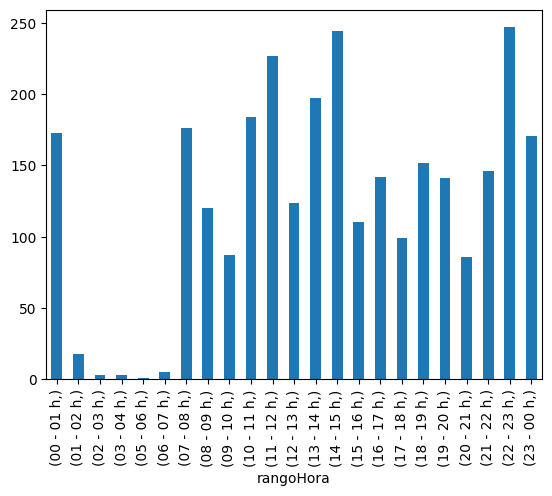

In [ ]:
# Crear una columna de 1 para realizar el conteo de mensajes
# df['# Mensajes por hora'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
# date_df = df.groupby('rangoHora').sum()[['# Mensajes por hora']]
date_df = df[['rangoHora']].value_counts().sort_index().plot.bar()
date_df
# fig = plt.subplots(date_df)

#### Número de mensajes a través del tiempo

In [ ]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por día'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('Fecha').sum()
date_df.reset_index(inplace=True)

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='Fecha', y='# Mensajes por día')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Cantidad de mensajes vs Tiempo',
             'y':0.96,
             'x':0.5,
             'xanchor': 'center'},
    font=dict(size=17))
fig.update_xaxes(title_text='Fecha', tickangle=45, nticks=35)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

#### Word Cloud de palabras más usadas por el grupo

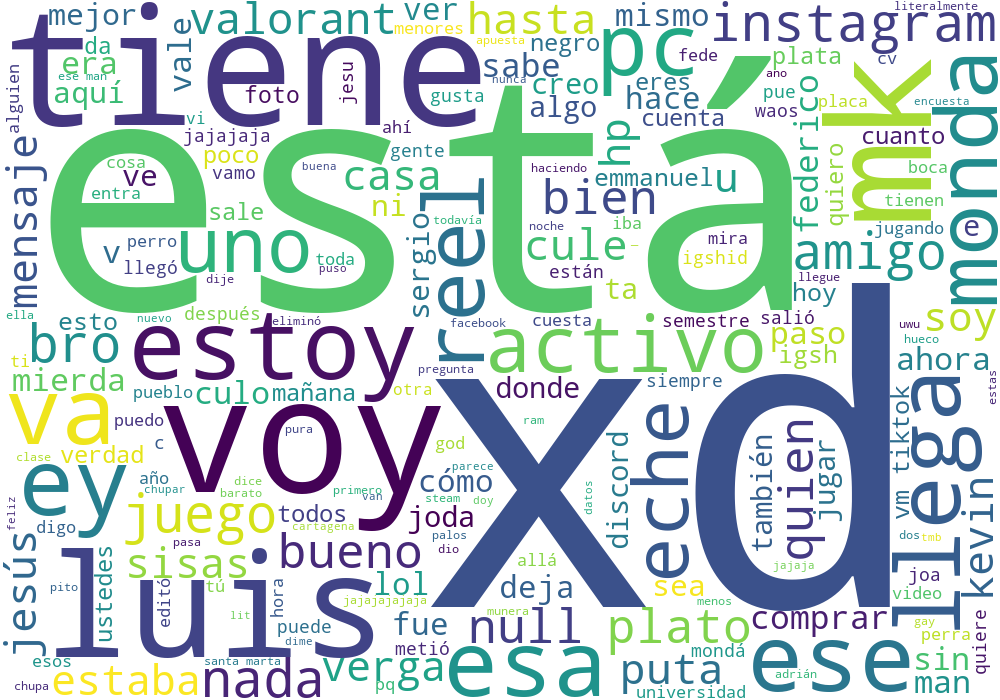

In [ ]:
# Crear un string que contendrá todas las palabras
total_palabras = ' '
stopwords = STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es',
                              'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic','nos', 'ya', 'hay', 'esta',
                              'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https','Media','omitted',
                              'y', 'mi', 'o', 'q', 'yo', 'al', 'porque','porqué','tengo','pa','muy','solo','cuando','igual','hacer','tu','tenía','tenia'])

# Obtener y acumular todas las palabras de cada mensaje
for mensaje in mensajes_df['Mensaje'].values:
    palabras = str(mensaje).lower().split() # Obtener las palabras de cada línea del txt
    for palabra in palabras:
        total_palabras = total_palabras + palabra + ' ' # Acumular todas las palabras

wordcloud = WordCloud(width = 1000, height = 700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(total_palabras)

# Plotear la nube de palabras más usadas
wordcloud.to_image()